In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from pandas import DataFrame
import datetime as dt
import talib

In [45]:
def draw(strategy:str):
    file = json.load(open("../backtest_results/.last_result.json"))["latest_backtest"]
    backtest_result = json.load(open(f"../backtest_results/{file}"))
    daily_profit = backtest_result["strategy"][f"{strategy}"]["daily_profit"]
    df = pd.DataFrame(data=daily_profit,columns=["date","profit"])
    df["cumsum_profit"]=df["profit"].cumsum()
    df["cumsum_profit"].plot()

def make_market_trend(df,key):
    #Make market trend data
    shifted = df[df[key] * df[key].shift()<0].copy()
    shifted = pd.concat([shifted,df.head(1)],axis=0)
    shifted.sort_index(inplace=True,ascending=True)
    shifted["start"] = shifted.index
    shifted["end"] = shifted["start"].shift(-1)
    shifted["value"] = shifted[key]
    return shifted[["end","value"]]


def plot_results(df:pd.DataFrame, market_trend:pd.DataFrame):
    fig,ax = plt.subplots()
    
    fig.set_dpi(720)
    fig.set_size_inches(10,6)
    
    for i in market_trend.index:
        row = market_trend.loc[i,:]
        start = i
        end = row["end"]
        color = "tab:green" if row["value"] > 0 else "tab:red" 
        ax.axvspan(start, end, color=color, alpha=0.1,linewidth=1)  #type: ignore
    
    plt.plot(df.index,df["Close"])
    
    plt.show()
    
def import_data(pair:str,timeframe:str):
    filename = f"/media/andy/UbuntuDisk/CryptoData/traderrobot/Aggregated/futures/{timeframe}/{pair}-{timeframe}.h5"
    df:DataFrame = pd.read_hdf(filename)
    return df 

In [32]:
def plot_market_cycle(
    pair:str,
    timeframe:str,
    start_date:dt.datetime,
    end_date:dt.datetime,
    multiple:int
    ):
    
    df = import_data(pair,timeframe)
    df = df.loc[start_date.timestamp()*1000:end_date.timestamp()*1000]
    
    MACD_FAST = 12
    MACD_SLOW = 26
    MACD_SIGNAL = 9
    _,_,slow = talib.MACD(                 #type: ignore
                df["Close"],
                fastperiod = multiple * MACD_FAST,
                slowperiod = multiple * MACD_SLOW,
                signalperiod = multiple * MACD_SIGNAL
            )
    df["MACD_SLOW"] = slow / df["Close"]
    market_df = make_market_trend(df,"MACD_SLOW")
    plot_results(df,market_df)

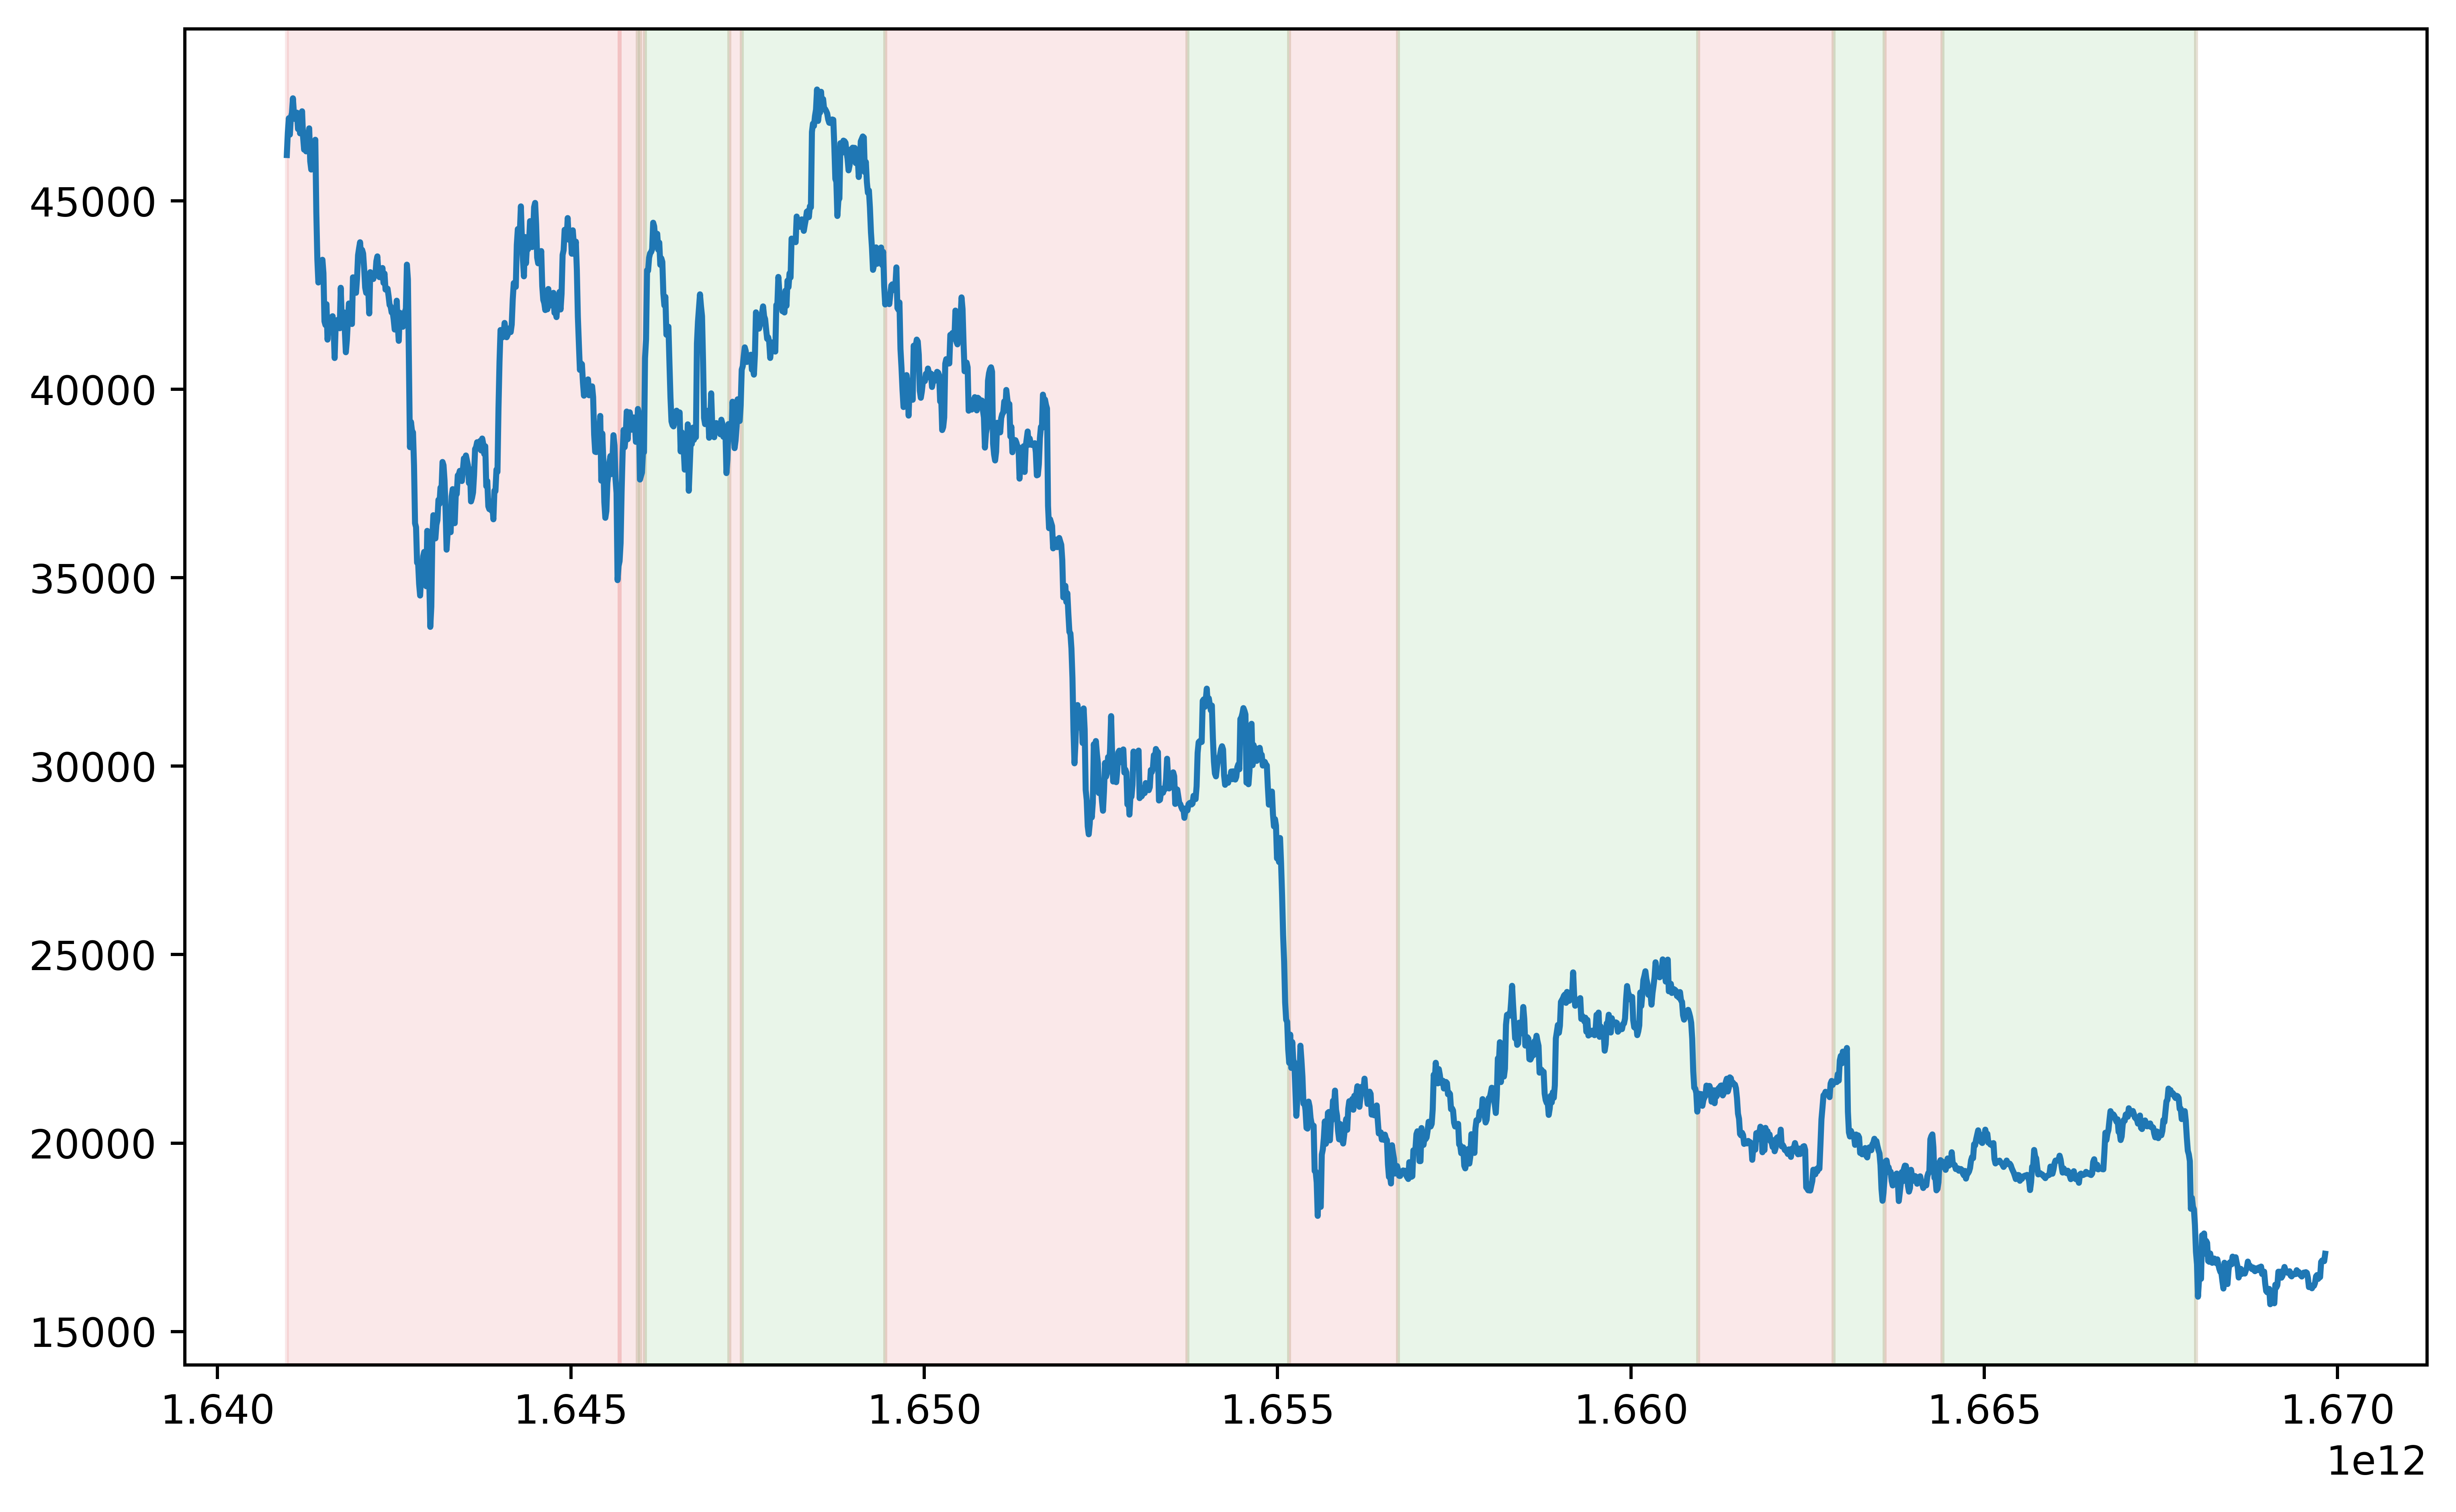

In [40]:
plot_market_cycle(
    pair = "BTCUSDT",
    timeframe="4h",
    start_date=dt.datetime(2022,1,1),
    end_date=dt.datetime(2022,12,1),
    multiple=9
)

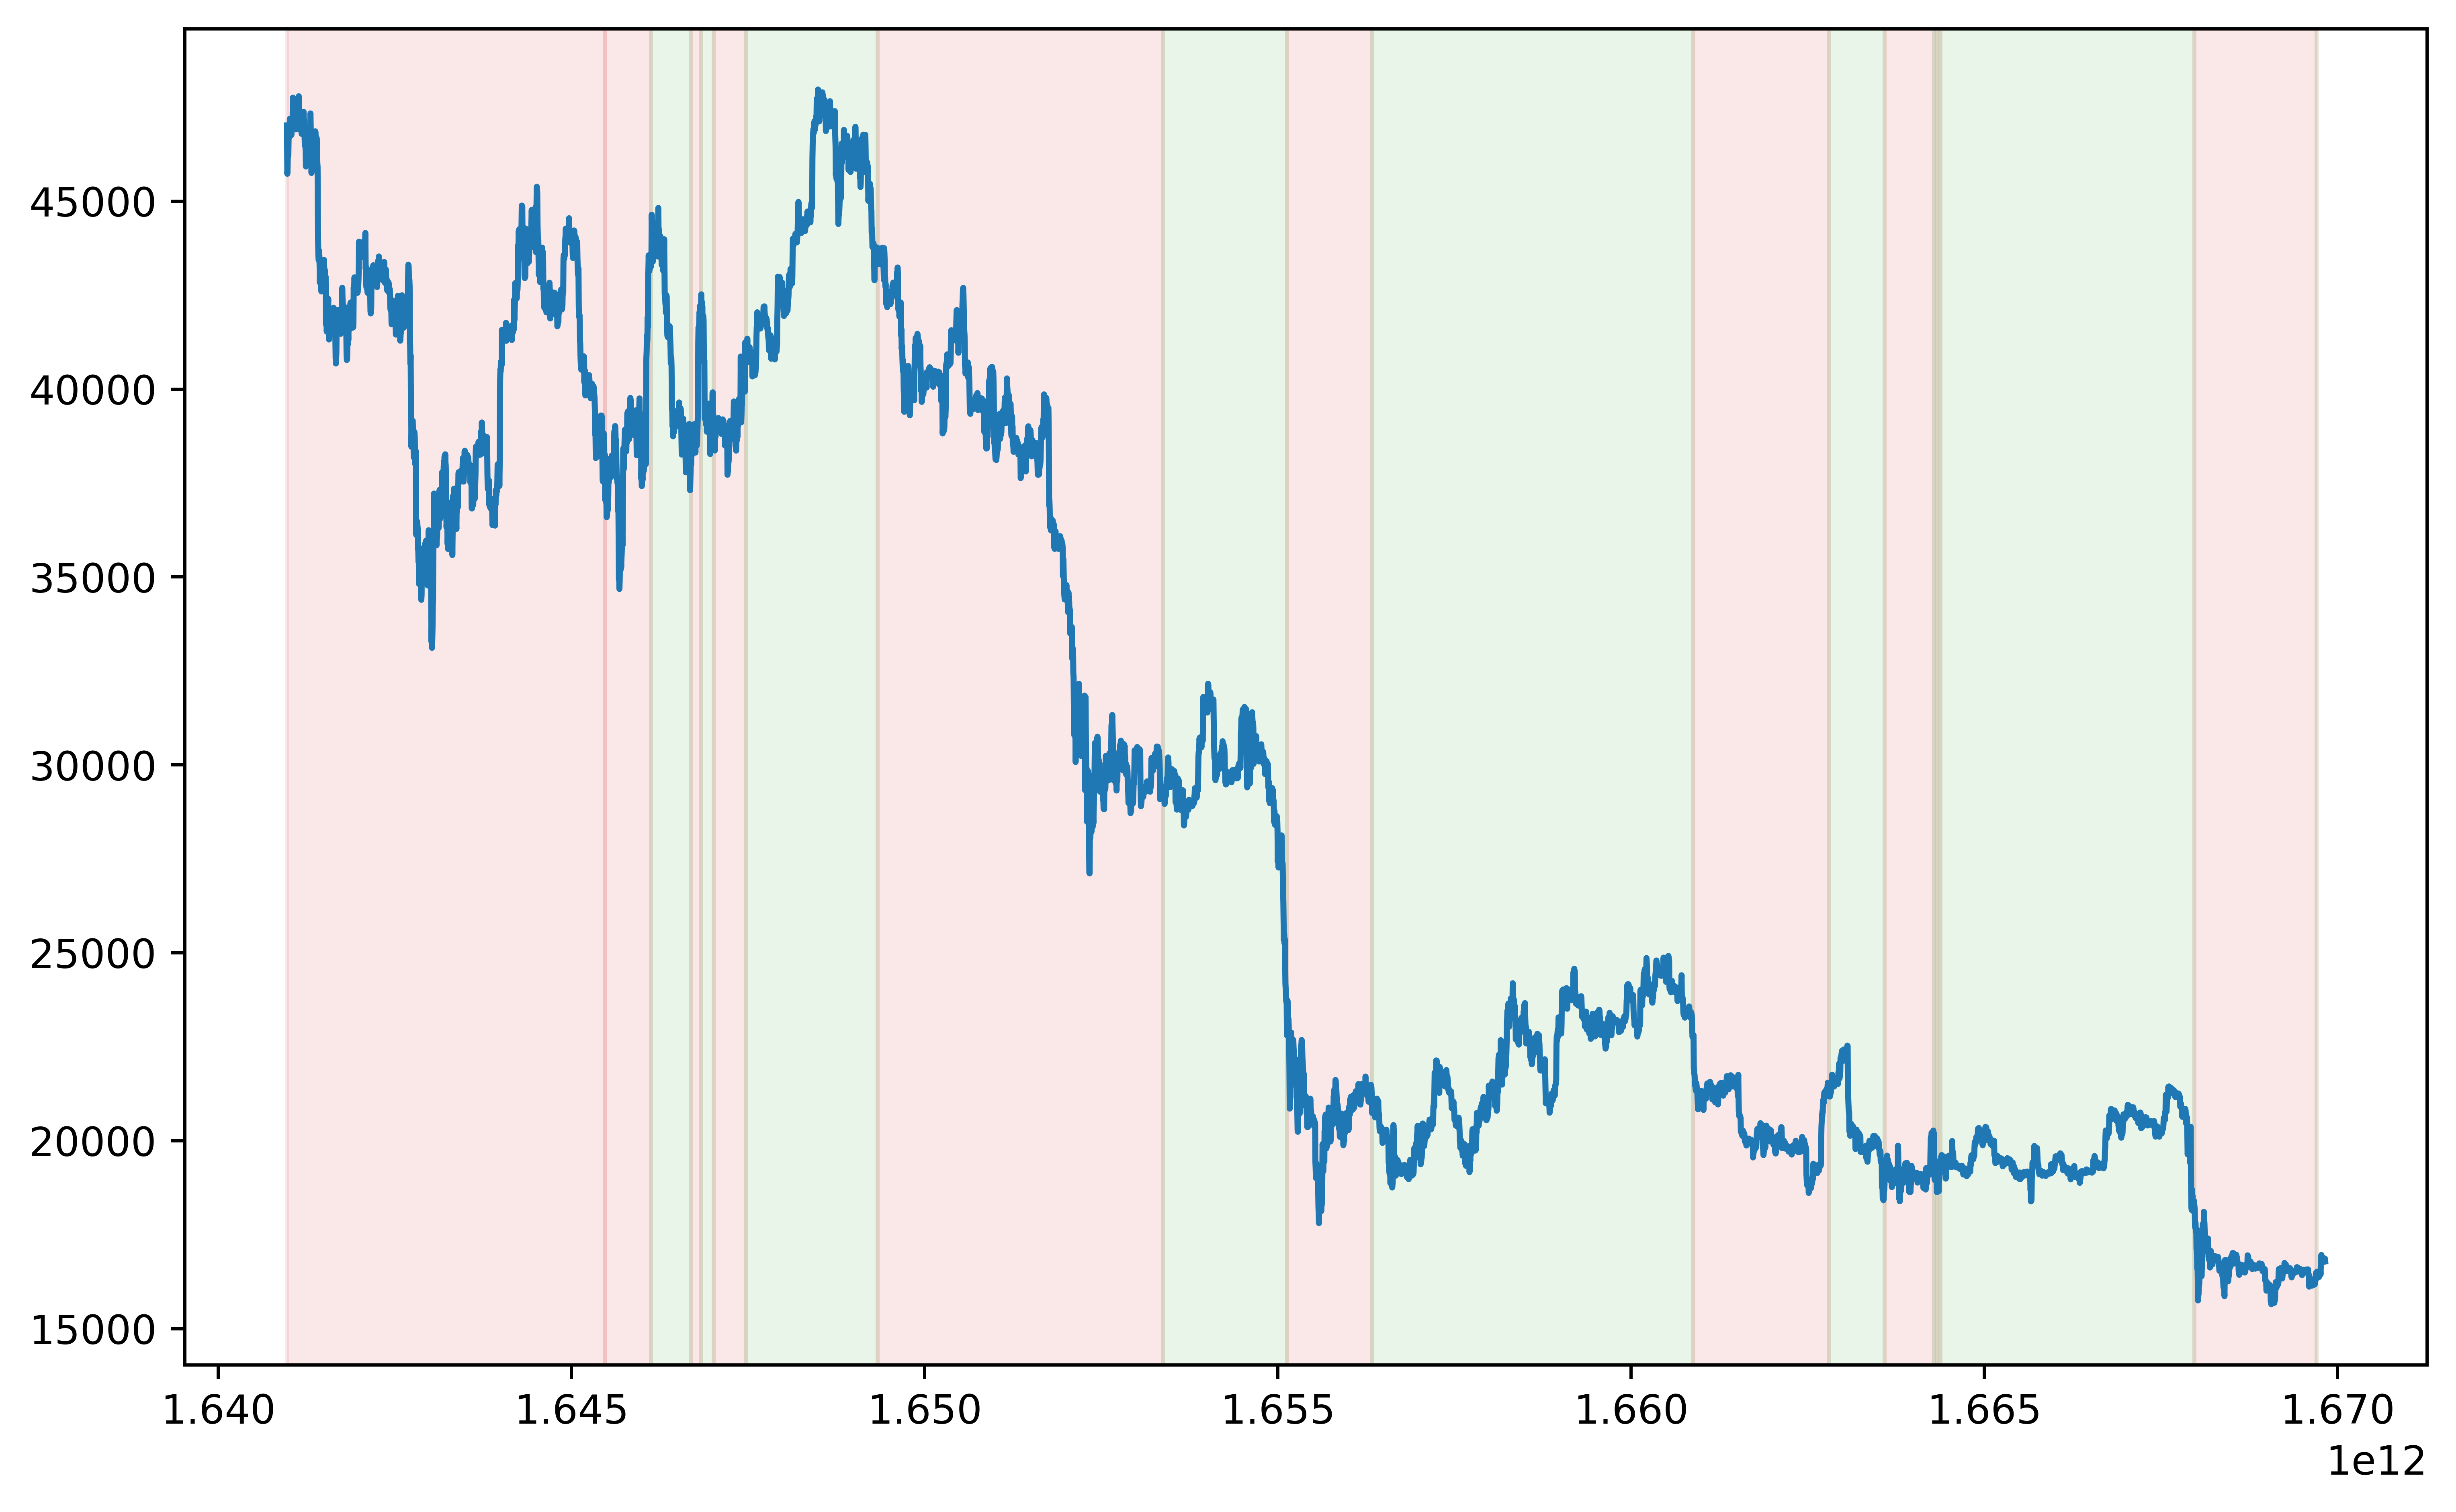

In [43]:
plot_market_cycle(
    pair = "BTCUSDT",
    timeframe="1h",
    start_date=dt.datetime(2022,1,1),
    end_date=dt.datetime(2022,12,1),
    multiple=30
)

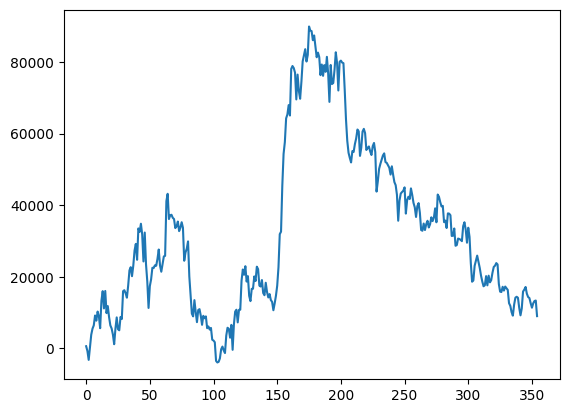

In [46]:
draw("SharpeLessExitArbitrage")